In [37]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sys
sys.path.append('..')
from functions.Multilinear_regression import *
from functions.evaluation import *
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

Compararemos la implementación de un modelo utilizando un framework y nuestra implementación propia a ver si dan los mismos resultados. 

El dataset se puede encontrar en `Data\salary.csv`. Estos son datos de profesores en una universidad con los cuales vamos a intentar predecir su salario. Como hay algunas variables categoricas vamos a hacer un one-hot encoding con algunas columnas. 

In [38]:
df = pd.read_csv('..\Data\salary.csv')
df = pd.get_dummies(df)
df.head()

,yrs.since.phd,yrs.service,salary,rank_AssocProf,rank_AsstProf,rank_Prof,discipline_A,discipline_B,sex_Female,sex_Male
0,19,18,139750,False,False,True,False,True,False,True
1,20,16,173200,False,False,True,False,True,False,True
2,4,3,79750,False,True,False,False,True,False,True
3,45,39,115000,False,False,True,False,True,False,True
4,40,41,141500,False,False,True,False,True,False,True


Vamos a dividir nuestro dataset en un conjunto de pruebas otro de entrenamiento.

In [39]:

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'salary'), df['salary'], test_size=0.2, random_state=42)

## Modelo estadistico con sklearn

Vamos a crear el modelo 3 veces para comparar todo. Primero utilizando minimos cuadrados para obtener los parámetros óptimos directamente lo cual podemos hacer con la libreria de Sklearn. 

In [40]:
model_stat = LinearRegression()
model_stat.fit(X_train, y_train)
[model_stat.intercept_] +  list(model_stat.coef_)

[93336.8669810207,
 506.78274727016327,
 -307.88522912181566,
 -7064.238273050716,
 -18571.068852445955,
 25635.307125496674,
 -8027.748718966921,
 8027.748718966921,
 -2182.9911443485003,
 2182.9911443485007]

Ahora vamos a graficar las metricas de los modelos para ver como funciona

In [41]:
y_pred_stat = model_stat.predict(X_test)
mse, mae, mape = get_metrics_regression(y_test, y_pred_stat)
print(f'MSE:{mse}   MAE:{mae}   MAPE:{mape}')

MSE:584765286.8530645   MAE:16703.47743313775   MAPE:0.15873779450133146


Ahora, estamos haciendo una regresión lineal por lo que haremos un análisis de residuos y varias pruebas para ver su eficiencia. 

Primero graficaremos los residuos en un histograma. De acuerdo a la teoría estos deberian seguir una distribución normal.

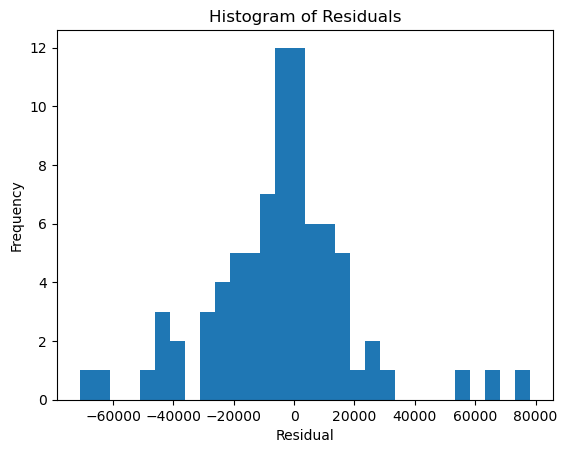

In [42]:
residuals = y_test - y_pred_stat
plt.hist(residuals, bins=30)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

Y ahora veremos el diagrama de qq-plot y una prueba de normalidad. 

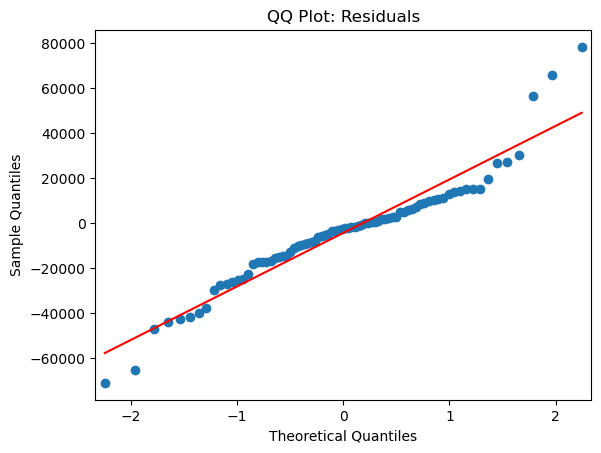

K-S test statistic: 0.1189
P-value: 0.1923


In [43]:
sm.qqplot(residuals, line='s')

# Add title and labels
plt.title(f"QQ Plot: Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")

# Display the plot
plt.show()
data_standardized = (residuals - np.mean(residuals)) / np.std(residuals)
# Perform the K-S test for normality
ks_statistic, ks_p_value = stats.kstest(data_standardized, 'norm')

print(f"K-S test statistic: {ks_statistic:.4f}")
print(f"P-value: {ks_p_value:.4f}")

Ahora vemos que hay algunos datos en las colas que nos causan problemas pero en general esto nos dice que siguen mas o menos una distribución normal lo cual es justo lo que buscamos.


Ahora al revisar homeostacisidad...

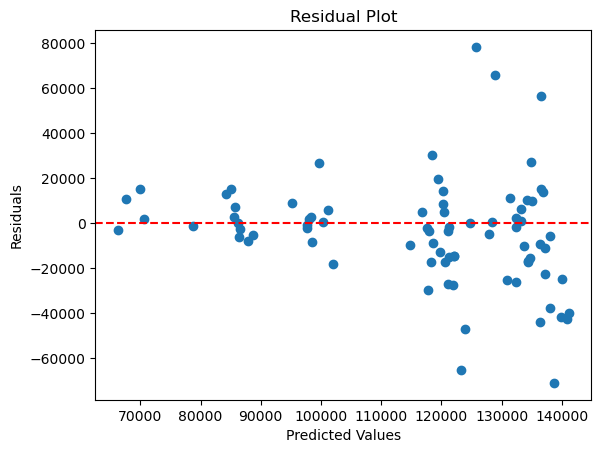

In [44]:
plt.scatter(y_pred_stat, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

Lamentablemente, vemos que tenemos un comportamiento de heteroestacicidad. :( Asi que vamos a intentar cambiar el modelo un poco para solucionar esto. 

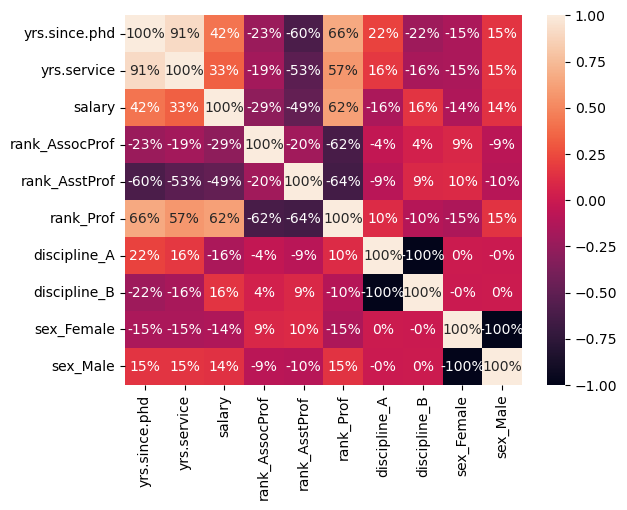

In [45]:
sns.heatmap(df.corr(), annot=True, fmt='.0%')
plt.show()

Veamos que yrs.since.phd y yrs.service tienen una alta correlación y ambas son variables independientes asi que quitaremos yrs.service.

Tambien vamos a agregar variables cuadradas para las que tengan más correlación con el salario. 

In [47]:
df = df.drop(columns = 'yrs.service')
df['yrs.since.phd_sqr'] = df['yrs.since.phd'].apply(lambda x: x**2)
df 

,yrs.since.phd,salary,rank_AssocProf,rank_AsstProf,rank_Prof,discipline_A,discipline_B,sex_Female,sex_Male,yrs.since.phd_sqr
0,19,139750,False,False,True,False,True,False,True,361
1,20,173200,False,False,True,False,True,False,True,400
2,4,79750,False,True,False,False,True,False,True,16
3,45,115000,False,False,True,False,True,False,True,2025
4,40,141500,False,False,True,False,True,False,True,1600
...,...,...,...,...,...,...,...,...,...,...
392,33,103106,False,False,True,True,False,False,True,1089
393,31,150564,False,False,True,True,False,False,True,961
394,42,101738,False,False,True,True,False,False,True,1764
395,25,95329,False,False,True,True,False,False,True,625


MSE:577336467.2201426   MAE:16429.425118022933   MAPE:0.1554068292302294


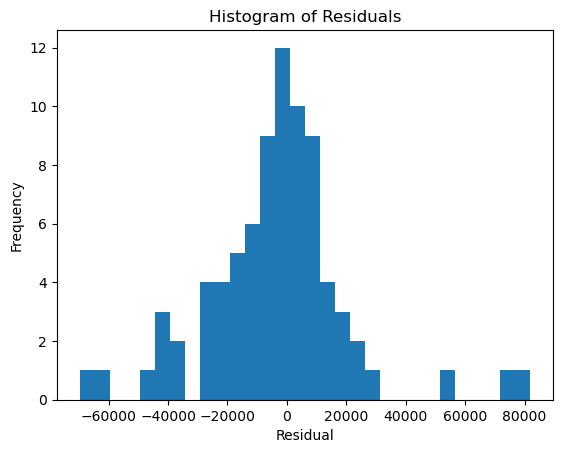

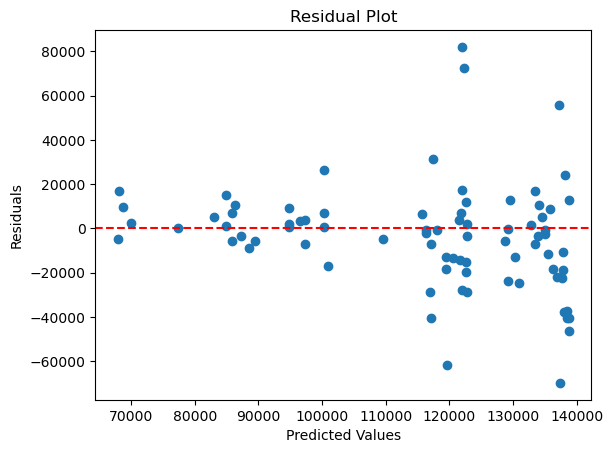

In [48]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'salary'), df['salary'], test_size=0.2, random_state=42)
model_stat = LinearRegression()
model_stat.fit(X_train, y_train)
y_pred_stat = model_stat.predict(X_test)
mse, mae, mape = get_metrics_regression(y_test, y_pred_stat)
print(f'MSE:{mse}   MAE:{mae}   MAPE:{mape}')
residuals = y_test - y_pred_stat
plt.hist(residuals, bins=30)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()
plt.scatter(y_pred_stat, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

Mejoramos un poco el modelo por lo que nuestros cambios fueron un exito. Sin embargo, tal vez generar un modelo no lineal nos arroja resultados todavia mejores. 

Por ejemplo ahora vamos a intentar un xgRegressor y un support vector regressor. 

In [55]:
from sklearn.svm import SVR
svr = SVR(kernel='poly', degree = 5,  C=1.0, epsilon=0.1)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
mse, mae, mape = get_metrics_regression(y_test, y_pred)
print(f'MSE:{mse}   MAE:{mae}   MAPE:{mape}')

MSE:788004078.4812084   MAE:20964.869032691164   MAPE:0.18924705926537472


Perdió el SVR

MSE:519956067.9138473   MAE:15941.55703125   MAPE:0.1448298373978488


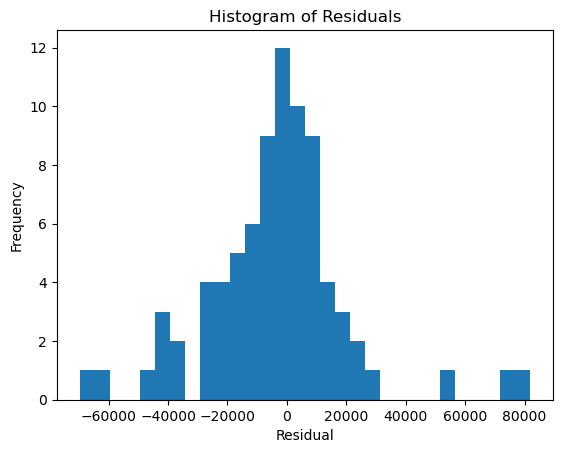

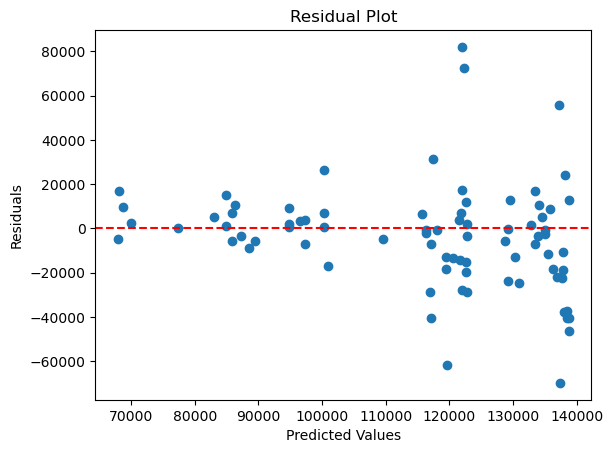

In [70]:
import xgboost as xgb
model = xgb.XGBRegressor(
    n_estimators=140,      # Number of boosting rounds
    learning_rate=0.025,     # Step size for each boosting round
    max_depth=4,           # Maximum depth of a tree
    min_child_weight=1,    # Minimum sum of instance weight needed in a child
    gamma=0,               # Minimum loss reduction required to make a further partition on a leaf node
    subsample=0.8,         # Fraction of samples used for fitting the trees
    colsample_bytree=0.8,  # Fraction of features used for fitting the trees
    objective='reg:squarederror',  # Loss function for regression
    random_state=42        # Seed for reproducibility
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse, mae, mape = get_metrics_regression(y_test, y_pred)
print(f'MSE:{mse}   MAE:{mae}   MAPE:{mape}')

residuals = y_test - y_pred_stat
plt.hist(residuals, bins=30)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()
plt.scatter(y_pred_stat, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

Aca sí ganó